In [152]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import concat as cbind
import scipy.stats as stats

## Autocorrelation

An autoregression model makes an assumption that the observations at previous time steps are useful to predict the value at the next time step.

This relationship between variables is called correlation.

If both variables change in the same direction (e.g. go up together or down together), this is called a positive correlation. If the variables move in opposite directions as values change (e.g. one goes up and one goes down), then this is called negative correlation.

We can use statistical measures to calculate the correlation between the output variable and values at previous time steps at various different lags. The stronger the correlation between the output variable and a specific lagged variable, the more weight that autoregression model can put on that variable when modeling.

Again, because the correlation is calculated between the variable and itself at previous time steps, it is called an autocorrelation. It is also called serial correlation because of the sequenced structure of time series data.

The correlation statistics can also help to choose which lag variables will be useful in a model and which will not.

Interestingly, if all lag variables show low or no correlation with the output variable, then it suggests that the time series problem may not be predictable. This can be very useful when getting started on a new dataset.

In this tutorial, we will investigate the autocorrelation of a univariate time series then develop an autoregression model and use it to make predictions.

Before we do that, let’s first review the Minimum Daily Temperatures data that will be used in the examples.

## Minimum Daily Temperatures Dataset

This dataset describes the minimum daily temperatures over 10 years (1981-1990) in the city Melbourne, Australia.

The units are in degrees Celsius and there are 3,650 observations. The source of the data is credited as the Australian Bureau of Meteorology.

https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv

Download the dataset into your current working directory with the filename “daily-minimum-temperatures.csv“.

The code below will load the dataset as a Pandas Series.


            Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8


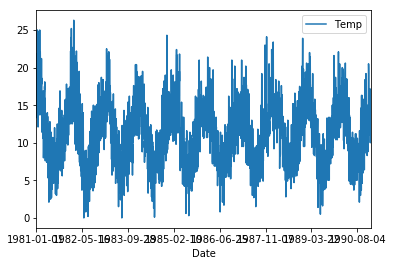

In [4]:
from pandas import read_csv
from matplotlib import pyplot
series = read_csv('daily-min-temperatures.csv', header=0, index_col=0)
print(series.head())
series.plot()
pyplot.show()

## Quick Check for Autocorrelation

There is a quick, visual check that we can do to see if there is an autocorrelation in our time series dataset.

We can plot the observation at the previous time step (t-1) with the observation at the next time step (t+1) as a scatter plot.

This could be done manually by first creating a lag version of the time series dataset and using a built-in scatter plot function in the Pandas library.

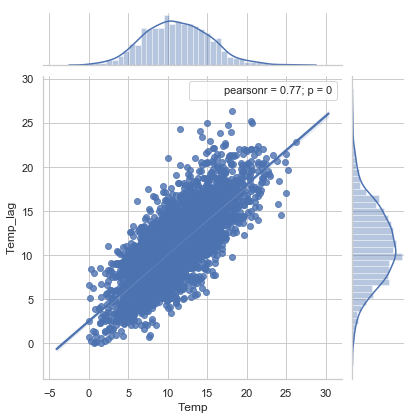

In [171]:
sns.set(style="whitegrid", color_codes=True)

series["Temp_lag"] = series["Temp"].shift(1)
sns.jointplot(series["Temp"], series["Temp_lag"], kind="reg").annotate(stats.pearsonr)


We can see a large ball of observations along a diagonal line of the plot. It clearly shows a relationship or some correlation.

This process could be repeated for any other lagged observation, such as if we wanted to review the relationship with the last 7 days or with the same day last month or last year.

Another quick check that we can do is to directly calculate the correlation between the observation and the lag variable.

We can use a statistical test like the Pearson correlation coefficient. This produces a number to summarize how correlated two variables are between -1 (negatively correlated) and +1 (positively correlated) with small values close to zero indicating low correlation and high values above 0.5 or below -0.5 showing high correlation.

Correlation can be calculated easily using the `corr()` function on the DataFrame of the lagged dataset.

The example below creates a lagged version of the Minimum Daily Temperatures dataset and calculates a correlation matrix of each column with other columns, including itself.

In [28]:
values = pd.DataFrame(series.Temp)
dataframe = cbind([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

         t-1      t+1
t-1  1.00000  0.77487
t+1  0.77487  1.00000


## Autocorrelation Plots

We can plot the correlation coefficient for each lag variable.

This can very quickly give an idea of which lag variables may be good candidates for use in a predictive model and how the relationship between the observation and its historic values changes over time.

We could manually calculate the correlation values for each lag variable and plot the result. Thankfully, Pandas provides a built-in plot called the `autocorrelation_plot()` function.

The plot provides the lag number along the x-axis and the correlation coefficient value between -1 and 1 on the y-axis. The plot also includes solid and dashed lines that indicate the 95% and 99% confidence interval for the correlation values. Correlation values above these lines are more significant than those below the line, providing a threshold or cutoff for selecting more relevant lag values.

In [172]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series["Temp"])
plt.show()

Running the example shows the swing in positive and negative correlation as the temperature values change across summer and winter seasons each previous year.

The statsmodels library also provides a version of the plot in the `plot_acf()` function as a line plot.

In [173]:
from statsmodels.graphics.tsaplots import plot_acf
fig = plt.figure(figsize=(20,6))

plot_acf(series["Temp"], lags=len(series)-1)
plot_acf(series["Temp"], lags=50)

plt.show()

<Figure size 1440x432 with 0 Axes>

Now that we know how to review the autocorrelation in our time series, let’s look at modeling it with an autoregression.

Before we do that, let’s establish a baseline performance.

## Persistence Model
Let’s say that we want to develop a model to predict the last 7 days of minimum temperatures in the dataset given all prior observations.

The simplest model that we could use to make predictions would be to persist the last observation. We can call this a persistence model and it provides a baseline of performance for the problem that we can use for comparison with an autoregression model.

We can develop a test harness for the problem by splitting the observations into training and test sets, with only the last 7 observations in the dataset assigned to the test set as “unseen” data that we wish to predict.

The predictions are made using a walk-forward validation model so that we can persist the most recent observations for the next day. This means that we are not making a 7-day forecast, but 7 1-day forecasts.

In [42]:
from sklearn.metrics import mean_squared_error

# create lagged dataset
values = DataFrame(series["Temp"])
df = cbind([values.shift(1), values], axis=1)
df.columns = ['t-1', 't+1']

# split into train and test sets
X = df.values
train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [52]:
sns.lineplot(y = train_X, x = range(len(train_X)))

Test MSE: 3.423


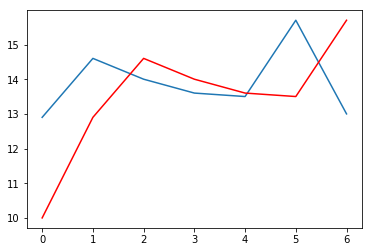

In [43]:
# persistence model
def model_persistence(x):
    return x

# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
    
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)

# plot predictions vs expected
plt.plot(test_y)
plt.plot(predictions, color='red')
plt.show()

## Autoregression Model

An autoregression model is a linear regression model that uses lagged variables as input variables.

We could calculate the linear regression model manually using the LinearRegession class in scikit-learn and manually specify the lag input variables to use.

Alternately, the statsmodels library provides an autoregression model that automatically selects an appropriate lag value using statistical tests and trains a linear regression model. It is provided in the AR class.

We can use this model by first creating the model `AR()` and then calling `fit()` to train it on our dataset. This returns an ARResult object.

Once fit, we can use the model to make a prediction by calling the `predict()` function for a number of observations in the future. This creates 1 7-day forecast, which is different from the persistence example above.

The complete example is listed below.

In [53]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error

# split dataset
X = series["Temp"]
train, test = X[1:len(X)-7], X[len(X)-7:]

In [105]:
# train autoregression
model = AR(train)
model_fit = model.fit()

print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

Lag: 29
Coefficients: const       0.557544
L1.Temp     0.588595
L2.Temp    -0.090826
L3.Temp     0.048262
L4.Temp     0.040065
L5.Temp     0.039302
L6.Temp     0.025946
L7.Temp     0.044668
L8.Temp     0.012768
L9.Temp     0.037436
L10.Temp   -0.000812
L11.Temp    0.004791
L12.Temp    0.018473
L13.Temp    0.026891
L14.Temp    0.000576
L15.Temp    0.024810
L16.Temp    0.007403
L17.Temp    0.009916
L18.Temp    0.034160
L19.Temp   -0.009120
L20.Temp    0.024213
L21.Temp    0.018787
L22.Temp    0.012184
L23.Temp   -0.018553
L24.Temp   -0.001772
L25.Temp    0.016732
L26.Temp    0.019762
L27.Temp    0.009832
L28.Temp    0.006227
L29.Temp   -0.001377
dtype: float64


/Users/caiooliveira/.pyenv/versions/3.7.3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [95]:
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
predictions = predictions.reset_index(drop=True)

/Users/caiooliveira/.pyenv/versions/3.7.3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


Running the example first prints the chosen optimal lag and the list of coefficients in the trained linear regression model.

We can see that a 29-lag model was chosen and trained. This is interesting given how close this lag is to the average number of days in a month.

The 7 day forecast is then printed and the mean squared error of the forecast is summarized.

In [106]:
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params.values)

for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
    
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Lag: 29
Coefficients: [ 5.57543506e-01  5.88595221e-01 -9.08257090e-02  4.82615092e-02
  4.00650265e-02  3.93020055e-02  2.59463738e-02  4.46675960e-02
  1.27681498e-02  3.74362239e-02 -8.11700276e-04  4.79081949e-03
  1.84731397e-02  2.68908418e-02  5.75906178e-04  2.48096415e-02
  7.40316579e-03  9.91622149e-03  3.41599123e-02 -9.11961877e-03
  2.42127561e-02  1.87870751e-02  1.21841870e-02 -1.85534575e-02
 -1.77162867e-03  1.67319894e-02  1.97615668e-02  9.83245087e-03
  6.22710723e-03 -1.37732255e-03]
predicted=11.871275, expected=12.900000
predicted=13.053794, expected=14.600000
predicted=13.532591, expected=14.000000
predicted=13.243126, expected=13.600000
predicted=13.091438, expected=13.500000
predicted=13.146989, expected=15.700000
predicted=13.176153, expected=13.000000
Test MSE: 1.502


A plot of the expected (blue) vs the predicted values (red) is made.

The forecast does look pretty good (about 1 degree Celsius out each day), with big deviation on day 5.

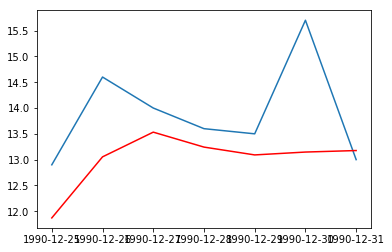

In [97]:
# plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

The statsmodels API does not make it easy to update the model as new observations become available.

One way would be to re-train the AR model each day as new observations become available, and that may be a valid approach, if not computationally expensive.

An alternative would be to use the learned coefficients and manually make predictions. This requires that the history of 29 prior observations be kept and that the coefficients be retrieved from the model and used in the regression equation to come up with new forecasts.

The coefficients are provided in an array with the intercept term followed by the coefficients for each lag variable starting at t-1 to t-n. We simply need to use them in the right order on the history of observations, as follows:

$$\hat{y} = b_0 + b_1X_1 + b_2X_2 ... b_nX_n$$

In [109]:
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error

# split dataset
X = series["Temp"]
train, test = X[1:len(X)-7], X[len(X)-7:]

# train autoregression
model = AR(train)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()

for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
    
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

predicted=11.871275, expected=12.900000
predicted=13.659297, expected=14.600000
predicted=14.349246, expected=14.000000
predicted=13.427454, expected=13.600000
predicted=13.374877, expected=13.500000
predicted=13.479991, expected=15.700000
predicted=14.765146, expected=13.000000
Test MSE: 1.451


/Users/caiooliveira/.pyenv/versions/3.7.3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
